# Extraindo dados do simepar 

### Estação de Curitiba

In [2]:
import json, requests
import pandas as pd
from datetime import datetime, timedelta, date
import datetime as dt
url = "http://www.simepar.br/simepar-services/sumariodiario"
#url = "http://www.simepar.br/simepar-services/sumariohorario"
#url = "http://www.simepar.br/simepar-services/sumariohorario"
params = {'datai': '2016-01-01', 'dataf': '2021-12-31', 'estacoes': '25264916', 'sensores': '9', 'operacoes': '2'}
response = requests.get(url=url, params=params)
data = response.json()
features = pd.DataFrame.from_dict(data)
features=features.sort_index(ascending=False)
features['data'] = features['data'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
features['year'] = pd.DatetimeIndex(features['data']).year
features['month'] = pd.DatetimeIndex(features['data']).month
features['day'] = pd.DatetimeIndex(features['data']).day
features = features.fillna(method='ffill')
features['Estaçao'] = features['valor']
features.drop(['data','estacaoId','sensorId','operacaoId','hora','minuto','valor'], axis=1, inplace=True)

In [3]:
import pandas as pd
from datetime import datetime, timedelta, date
import datetime as dt
features2 = pd.read_csv('wind2016-2021teste.csv')
features2=features2.sort_index(ascending=False)
features['ECMWF'] = features2['wind_speed']

In [4]:
features

,year,month,day,Estaçao,ECMWF
2190,2016,1,1,7.8,10.95
2189,2016,1,2,7.5,8.84
2188,2016,1,3,8.6,6.71
2187,2016,1,4,8.1,5.18
2186,2016,1,5,7.4,8.87
...,...,...,...,...,...
4,2021,12,27,8.5,13.39
3,2021,12,28,10.3,11.89
2,2021,12,29,10.2,9.94
1,2021,12,30,7.7,8.20


In [5]:
features.head(2)

,year,month,day,Estaçao,ECMWF
2190,2016,1,1,7.8,10.95
2189,2016,1,2,7.5,8.84


# Iniciando o Random Forest

In [6]:
print('The shape of our features is:', features.shape)

The shape of our features is: (2191, 5)


In [7]:
# Estatísticas descritivas para cada coluna
features.describe()

,year,month,day,Estaçao,ECMWF
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,2018.499772,6.521680,15.739388,8.589457,9.281698
std,1.708928,3.450546,8.799756,2.482813,2.710853
min,2016.000000,1.000000,1.000000,3.200000,2.710000
25%,2017.000000,4.000000,8.000000,7.000000,7.395000
50%,2019.000000,7.000000,16.000000,8.100000,9.260000
75%,2020.000000,10.000000,23.000000,9.700000,11.030000
max,2021.000000,12.000000,31.000000,27.200000,19.590000


In [8]:
# Codificando os dados usando pandas get_dummies
features = pd.get_dummies(features)

In [9]:
#CURITIBA
# Use numpy para converter em arrays 
import numpy as np
# Labels são os valores que queremos prever 
labels = np.array(features['ECMWF'])
# Remova os rótulos dos recursos 
# axis 1 refere-se às colunas 
features= features.drop('ECMWF', axis = 1)
# Salvando nomes de recursos para uso posterior 
feature_list = list(features.columns)
# Converta em recursos de matriz numpy 
features = np.array(features)

In [10]:
# Skicit-learn para dividir dados em conjuntos de treinamento e teste
from sklearn.model_selection import train_test_split
# Divida os dados em conjuntos de treinamento e teste
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [11]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1643, 4)
Training Labels Shape: (1643,)
Testing Features Shape: (548, 4)
Testing Labels Shape: (548,)


In [12]:
# Dados da estação de Ponta GroSsa para validação
baseline_preds = test_features[:, feature_list.index('Estaçao')]
# Erros de linha de base e exibir erro de linha de base médio
baseline_errors = abs(baseline_preds - test_labels)
print('valor baseline error: ', round(np.mean(baseline_errors), 2))

valor baseline error:  2.9


In [13]:
from xgboost import XGBRegressor
rf = XGBRegressor(n_estimators=300,max_depth = 3,random_state =0,learning_rate= 0.01)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)

In [14]:
import sklearn.metrics as sm
print("Erro médio absoluto =", round(sm.mean_absolute_error(test_labels, predictions), 2)) 
print("Erro Quadrático Médio =", round(sm.mean_squared_error(test_labels, predictions), 2)) 
print("Desvio médio absoluto =", round(sm.median_absolute_error(test_labels, predictions), 2)) 
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Acurácia:', round(accuracy, 2), '%.')

Erro médio absoluto = 2.09
Erro Quadrático Médio = 6.97
Desvio médio absoluto = 1.74
Acurácia: 73.73 %.


In [15]:
#feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: month                Importance: 0.5099999904632568
Variable: Estaçao              Importance: 0.17000000178813934
Variable: year                 Importance: 0.1599999964237213
Variable: day                  Importance: 0.1599999964237213


In [16]:
rf_most_important = XGBRegressor(n_estimators= 100, random_state=0)
important_indices = [feature_list.index('Estaçao')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
rf_most_important.fit(train_important, train_labels)
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
print("Erro médio absoluto =", round(sm.mean_absolute_error(test_labels, predictions), 2)) 
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Acurácia:', round(accuracy, 2), '%.')

Erro médio absoluto = 2.16
Acurácia: 71.35 %.


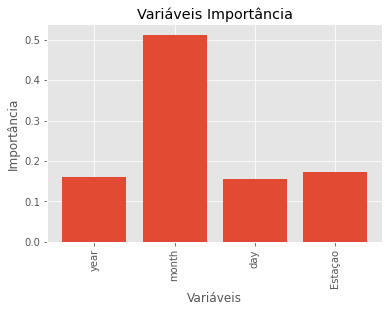

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
# Defina o estilo
plt.style.use('ggplot')
#lista de x locais para plotagem
x_values = list(range(len(importances)))
# Utilizando barras
plt.bar(x_values, importances, orientation = 'vertical')
# Marcar o eixo x
plt.xticks(x_values, feature_list, rotation='vertical')
# titulo
plt.ylabel('Importância'); plt.xlabel('Variáveis'); plt.title('Variáveis Importância');

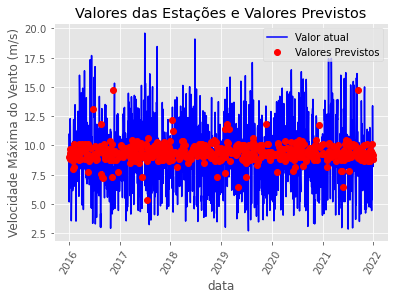

In [18]:
import datetime
#Datas dos valores de treinamento
from datetime import datetime, timedelta
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]
#Listando e depois convertendo para objeto
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe com valores e datas verdadeiros
true_data = pd.DataFrame(data = {'date': dates, 'valor': labels})
#Datas de previsões
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
#Colunas de datas
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
#Convertendo  to datetime objects
test_dates = [datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
#Dataframe com previsões e datas
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plote os valores reais
plt.plot(true_data['date'], true_data['valor'], 'b-', label = 'Valor atual')
# Plote os valores previstos
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'Valores Previstos')
plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('data'); plt.ylabel('Velocidade Máxima do Vento (m/s)'); plt.title('Valores das Estações e Valores Previstos');

MSE: 7.63


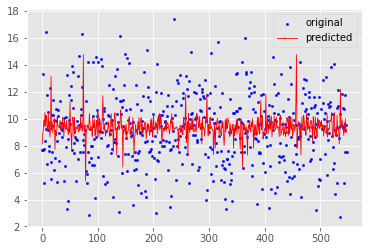

In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_labels, predictions)

print("MSE: %.2f" % mse)


#Finally, we'll visualize the original and predicted values in a plot.

x_ax = range(len(test_labels))
plt.scatter(x_ax, test_labels, s=5, color="blue", label="original")
plt.plot(x_ax, predictions, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()